In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
import sklearn, sklearn.metrics

import glob
import captum
import latentshift
import classifiers
import ct_models
import ct_datasets
import skimage

/tmp/ipykernel_221338/958535668.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = 'cuda'

In [4]:
model = classifiers.phecode.PheCodeClassifier().to(device)

Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
weights_path = '/home/groups/akshaysc/joecohen/weights/'
ae_folder = '2023-07-27T19-35-51_ct_vqgan_sdd'
ae_folder = '2023-12-25T10-26-40_ct2_vqgan256_sddd'
ae = ct_models.VQGAN(
    ckpt_path=f'{weights_path}/{ae_folder}/checkpoints/last.ckpt',
    yaml_path=glob.glob(f'{weights_path}/{ae_folder}/configs/*-project.yaml')[0],
    resize=256,
).to(device)

Working with z of shape (1, 256, 4, 4) = 4096 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [6]:
!ls /home/users/joecohen/group/phecode_scans/pacemaker/

AC423c71a_0000.nii.gz  AC4240355_0000.nii.gz  AC4242a48_0000.nii.gz
AC423d550_0000.nii.gz  AC4240711_0000.nii.gz  AC424343e_0000.nii.gz
AC423efff_0000.nii.gz  AC42409a7_0000.nii.gz  isolated_scans.zip
AC4240174_0000.nii.gz  AC4240d86_0000.nii.gz  __MACOSX


In [7]:
# data = ct_datasets.NIFTI_Dataset('/home/users/joecohen/group/phecode_scans/obesity/', 
#                                 resolution=224)

In [8]:
data = ct_datasets.NIFTI_Dataset('/home/users/joecohen/oak/cts/', 
                                resolution=224)

In [9]:
len(data)

1

In [10]:
img = data[0]['image'][None,...]
img.shape

torch.Size([1, 1, 224, 224, 134])

In [11]:
img.min(), img.max()

(metatensor(0.), metatensor(1.))

In [12]:
# for i in range(1):
#     sample = data[i]
#     img = sample['image'][None,...]
#     with torch.no_grad():
#         o = model(img.cuda()).cpu()
#     print(i, os.path.basename(sample['image_path']))

#     for ind, target in [(i, target) for i, target in enumerate(model.targets) if 'pacemaker' in target]:
#         print("   " + str(float(o[:,ind])) + "  " + model.targets[ind])

In [13]:
# for i in range(1):
#     sample = data[i]
#     img = sample['image'][None,...]
#     with torch.no_grad():
#         o = model(img.cuda()).cpu()
#     print(i, os.path.basename(sample['image_path']))

#     for ind, target in [(i, target) for i, target in enumerate(model.targets) if 'effusion' in target.lower()]:
#         print("   " + str(float(o[:,ind])) + "  " + model.targets[ind])

In [14]:
# ae2 = ct_models.SliceAEFull(ae, 0, 0)
# for i in range(2):
#     sample = data[i]
#     img = sample['image'][None,...]

#     with torch.no_grad():
#         imgp = ae2.decode(ae2.encode(img.cuda()))
#         o = model(imgp)
#     print(i, os.path.basename(sample['image_path']))
#     topk = o.topk(10)
#     for val, ind in zip(topk.values.cpu().numpy()[0], topk.indices.cpu().numpy()[0]):
#         print("   " + str(val) + "  " + model.targets[ind])

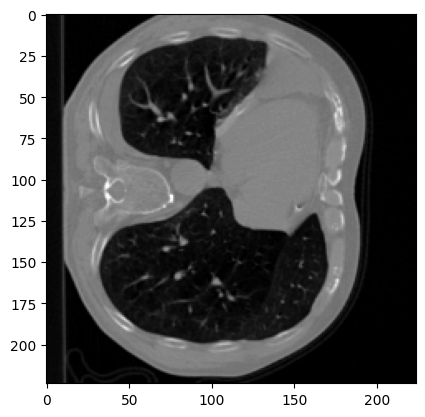

In [15]:
plt.imshow(img[0,0,:,:,50], cmap='gray');

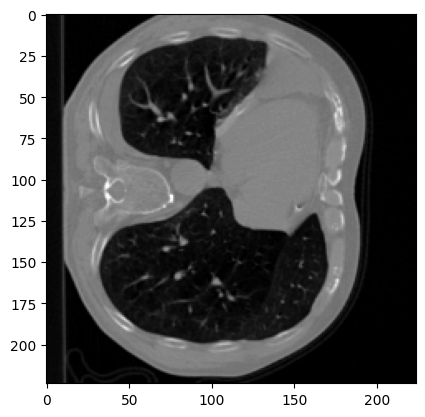

In [16]:
x = img[:,:,:,:,50]
plt.imshow(x[0][0].cpu().detach().numpy(), cmap='gray');

In [17]:
z = ae.encode(x.cuda())

In [18]:
img2 = ae.decode(z)

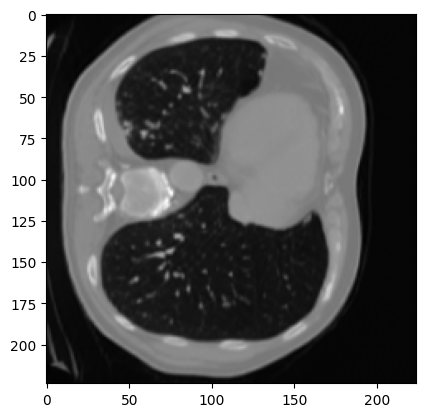

In [19]:
plt.imshow(img2[0][0].cpu().detach().numpy(), cmap='gray');

In [95]:
attr = captum.attr.LatentShift(
    latentshift.alignment.ModelWrapper(
        model, 
        target='Pleurisy; pleural effusion', 
        adjustment=lambda x: x+0.4,
        rename_model='', sigmoid=False), 
    ct_models.SliceAEFull(ae, 45,55),
)
output = attr.attribute(img.cuda(), target=0,
                        #fix_range=[-1600,0], 
                        return_dicts = True,
                        apply_sigmoid = False,
                        search_max_steps = 20000,
                       )[0]
#plt.imshow(output['heatmap'][0]);

Shift: 0, Pred: 0.45309698581695557, pixel_diff: 0.0, sum*diff_pct: 130881.390625
Shift: -10.0, Pred: 0.4530724287033081, pixel_diff: 2.8460350036621094, sum*diff_pct: 130881.390625
Shift: -21.0, Pred: 0.45304548740386963, pixel_diff: 5.975874900817871, sum*diff_pct: 130881.390625
Shift: -34.0, Pred: 0.45301321148872375, pixel_diff: 9.670404434204102, sum*diff_pct: 130881.390625
Shift: -48.0, Pred: 0.4529780149459839, pixel_diff: 13.65176773071289, sum*diff_pct: 130881.390625
Shift: -63.0, Pred: 0.4529413878917694, pixel_diff: 17.915922164916992, sum*diff_pct: 130881.390625
Shift: -80.0, Pred: 0.45290064811706543, pixel_diff: 22.753334045410156, sum*diff_pct: 130881.390625
Shift: -98.0, Pred: 0.45285871624946594, pixel_diff: 27.869773864746094, sum*diff_pct: 130881.390625
Shift: -118.0, Pred: 0.45281362533569336, pixel_diff: 33.555328369140625, sum*diff_pct: 130881.390625
Shift: -140.0, Pred: 0.45276540517807007, pixel_diff: 39.809547424316406, sum*diff_pct: 130881.390625
Shift: -164.0

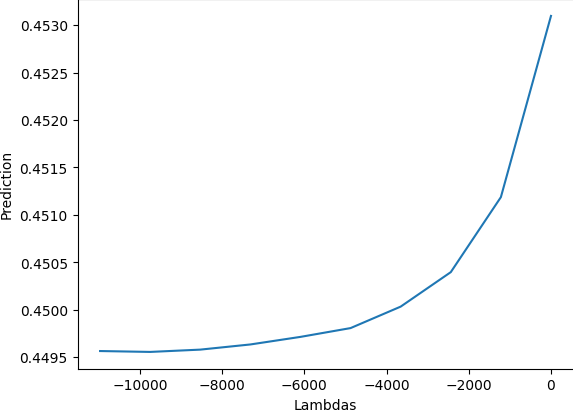

In [96]:
plt.plot(output['lambdas'],output['preds']);
plt.xlabel('Lambdas');
plt.ylabel('Prediction');

In [97]:
single_diffs = np.abs(output['heatmap']).sum(0).sum(0).sum(0)

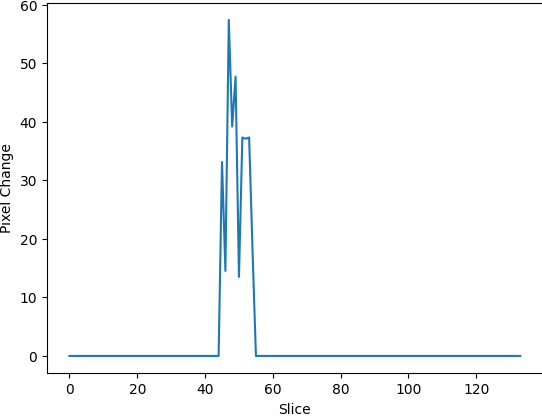

In [98]:
plt.plot(single_diffs);
plt.xlabel('Slice');
plt.ylabel('Pixel Change');

In [99]:
output['heatmap'].shape

(1, 224, 224, 134)

In [100]:
idx = output['heatmap'].sum(1).sum(1).argmax()
idx

47

In [110]:
idx =47

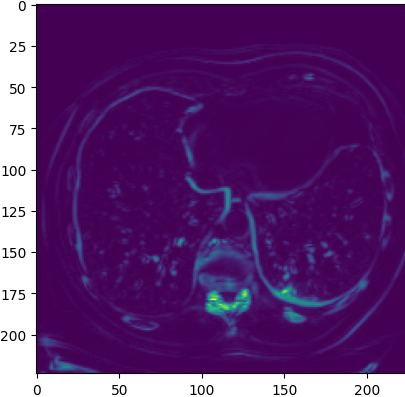

In [111]:
plt.imshow(skimage.transform.rotate(output['heatmap'][0,:,::-1,idx], -90));

In [127]:
images = [output['generated_images'][i, :,::-1,:,idx] for i in range(len(output['generated_images']))]
images = [skimage.transform.rotate(img[0],90)[None,...] for img in images]


In [128]:
images = [ct_datasets.window_level(img, -1000, 100) for img in images]

0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125


In [129]:
images[0].shape

(1, 224, 224)

In [130]:
# images = [output['generated_images'][i, :,::-1,150,:] for i in range(len(output['generated_images']))]
# images = [skimage.transform.rotate(img[0],90)[None,...] for img in images]


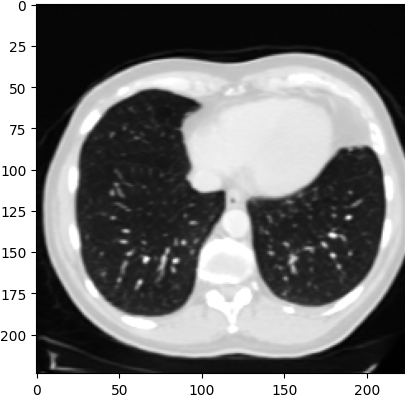

In [131]:
plt.imshow(images[0][0], cmap='gray');

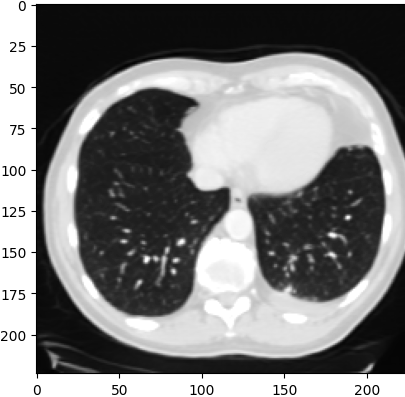

In [132]:
plt.imshow(images[-1][0], cmap='gray');

In [143]:
latentshift.video_utils.generate_video({'generated_images':images, 'preds':np.array(output['preds'])-(np.array(output['preds']).min())}, "effusion", show_pred=True, watermark=False, cmap='gray', 
                                       extra_loops=3,
                                      ffmpeg_path='/share/software/user/open/ffmpeg/5.0/bin/ffmpeg',
                                      resize=512)


/share/software/user/open/ffmpeg/5.0/bin/ffmpeg -loglevel quiet -stats -y -i effusion/image-%d.png -c:v libx264 -vf scale=-2:512 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'effusion.mp4'


b''


frame=   40 fps=0.0 q=-1.0 Lsize=      69kB time=00:00:01.56 bitrate= 362.6kbits/s speed=4.55x    


In [152]:
latentshift.video_utils.write_frame(images[-1][0], 'effusion-1.png', cmap='gray', watermark=False)

In [153]:
latentshift.video_utils.write_frame(images[0][0], 'effusion0.png', cmap='gray', watermark=False)

In [34]:
outputs = []
batch_size = 15
for i in tqdm(range(0, img.shape[-1], batch_size)):
    print(f'Slices {i}-{i+batch_size}')
    attr = captum.attr.LatentShift(
        latentshift.alignment.ModelWrapper(
            model, 
            target='Pleurisy; pleural effusion',
            adjustment=lambda x: x+4, 
            rename_model='', sigmoid=False),
        ct_models.SliceAEFull(ae, i, i+batch_size)
    )
    output = attr.attribute(img.cuda(), target=0,
                            #fix_range=[-700,0],
                            return_dicts = True,
                            apply_sigmoid = False,
                            lambda_sweep_steps = 2,
                            search_max_steps = 20000,
                            verbose=False,
                           )[0]
    outputs.append(output)

  0%|          | 0/9 [00:00<?, ?it/s]

Slices 0-15
Slices 15-30
Slices 30-45
Slices 45-60
Slices 60-75
Slices 75-90
Slices 90-105
Slices 105-120
Slices 120-135


In [35]:
len(outputs)

9

In [36]:
pred_changes = np.concatenate([[np.min(o['preds'])]*batch_size for o in outputs])

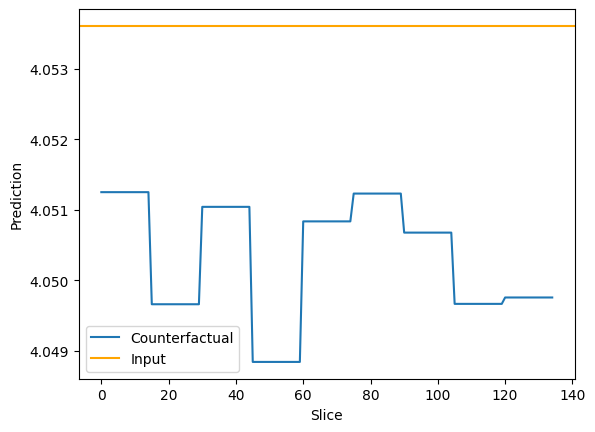

In [37]:
plt.plot(pred_changes, label='Counterfactual');
plt.axhline(outputs[0]['preds'][-1], label='Input', c='orange')
plt.xlabel('Slice');
plt.ylabel('Prediction');
plt.legend();

In [38]:
heatmaps = np.concatenate([o['heatmap'] for o in outputs], 3)

In [39]:
raw_diffs = np.concatenate([np.abs(o['heatmap']**2).sum(0).sum(0).sum(0) for o in outputs])
diffs = raw_diffs[raw_diffs != 0]

In [40]:
heatmaps1 = heatmaps[:,:,:,raw_diffs != 0]
images_reconstruction = np.concatenate([o['generated_images'][-1] for o in outputs], 3)
images_counterfactual = np.concatenate([o['generated_images'][0] for o in outputs], 3)

In [41]:
images_reconstruction = images_reconstruction[...,raw_diffs != 0]
images_counterfactual = images_counterfactual[...,raw_diffs != 0]

In [42]:
images_reconstruction = [skimage.transform.rotate(img,90) for img in images_reconstruction]
images_counterfactual = [skimage.transform.rotate(img,90) for img in images_counterfactual]
heatmaps1 = [skimage.transform.rotate(img,90) for img in heatmaps1]

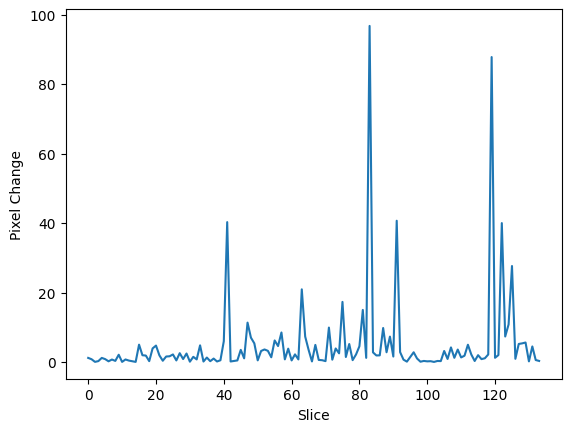

In [43]:
plt.plot(diffs);
plt.xlabel('Slice');
plt.ylabel('Pixel Change');

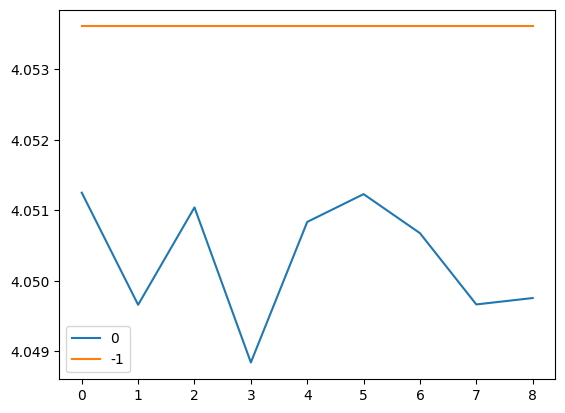

In [44]:
plt.plot([output['preds'][0] for output in outputs], label='0')
plt.plot([output['preds'][-1] for output in outputs], label='-1')
plt.legend();

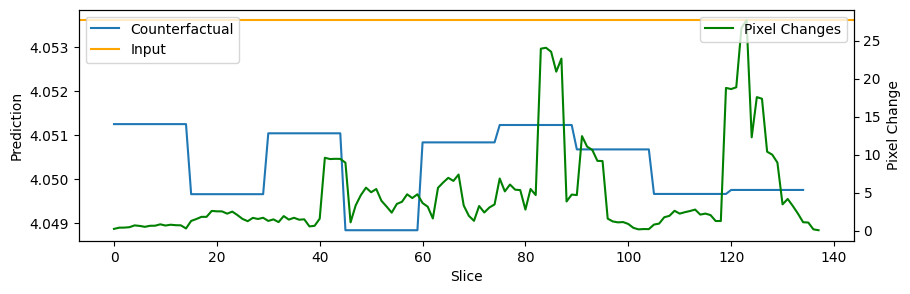

In [45]:
plt.figure(figsize=(10,3))
lines = []
lines.append(plt.plot(pred_changes, label='Counterfactual'))
lines.append([plt.axhline(outputs[0]['preds'][-1], label='Input', c='orange')])
plt.ylabel('Prediction');
plt.legend(loc='upper left')
plt.xlabel('Slice');
plt.twinx()
xnew = np.linspace(0, len(diffs), len(diffs)) 
smoothed_diffs = np.convolve(diffs, np.ones(5)/5, mode='full')
lines.append(plt.plot(smoothed_diffs, label='Pixel Changes', c='green'))
plt.xlabel('Slice');
plt.ylabel('Pixel Change');
plt.legend();
plt.legend(loc='upper right');


In [46]:
np.argmax(diffs)

83

In [47]:
np.argmax(-pred_changes)

45

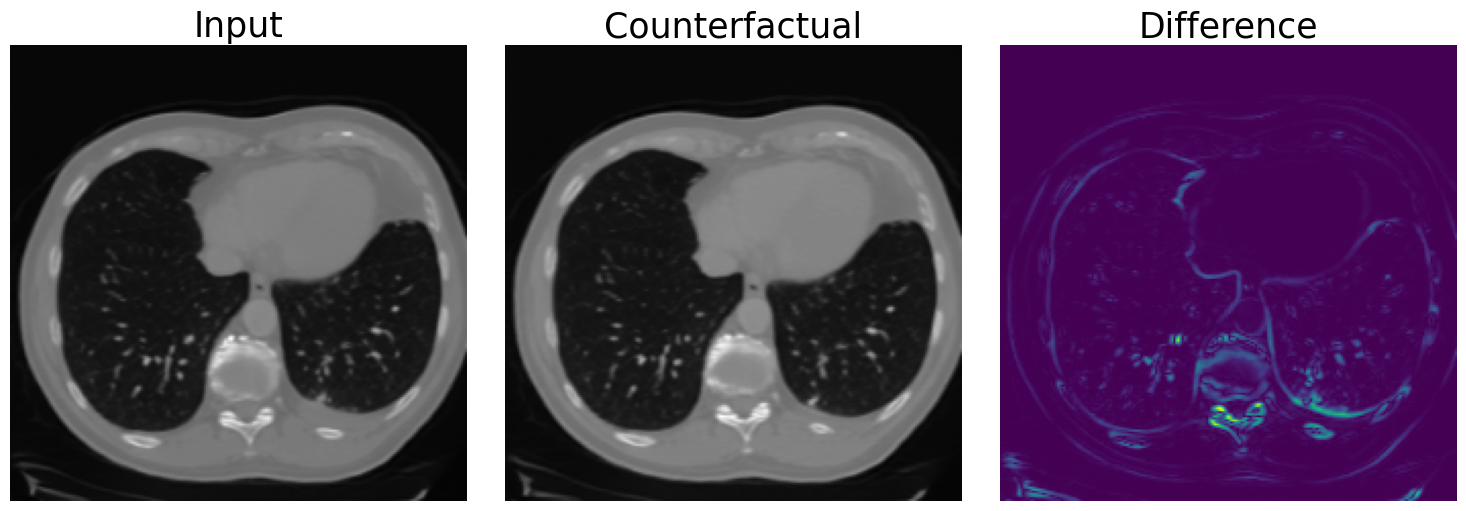

In [61]:
idx_slice = 47
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0][:,::-1,idx_slice], cmap='gray')
axs[0].set_title('Input', size=25)
axs[1].imshow(images_counterfactual[0][:,::-1,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual', size=25)
axs[2].imshow(heatmaps1[0][:,::-1,idx_slice])
axs[2].set_title('Difference', size=25);
[axs[i].axis('off') for i in range(len(axs))]
plt.tight_layout()

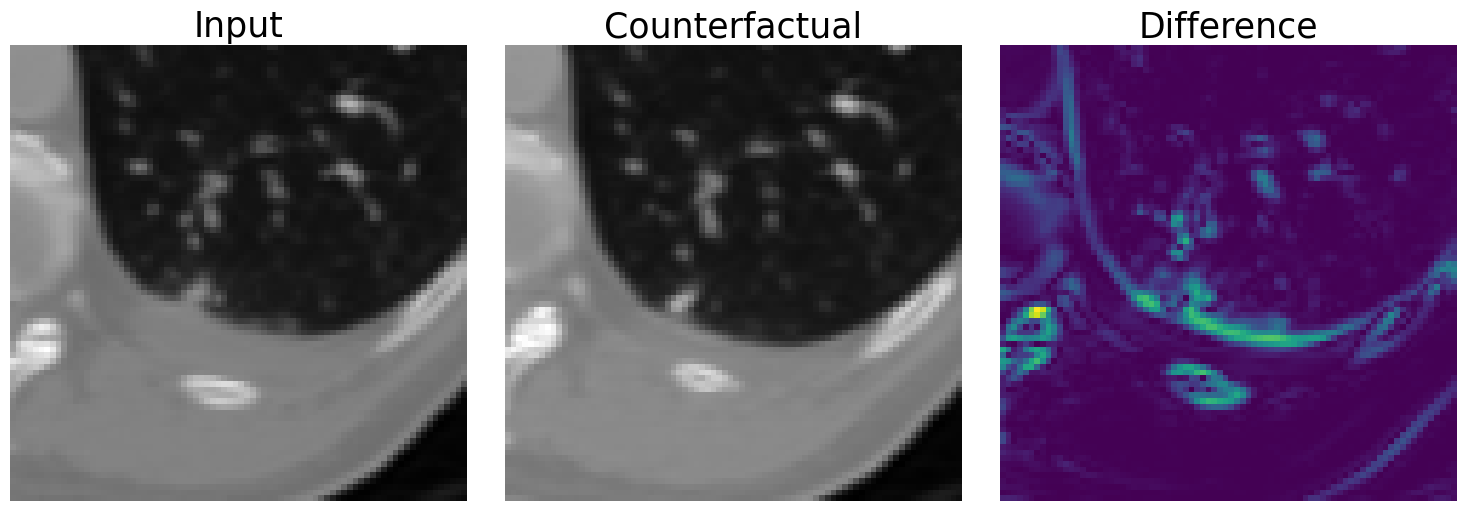

In [79]:
idx_slice = 47
zoom_xy = 130,120 
zoom_size = 80
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0][:,::-1,idx_slice][zoom_xy[0]:zoom_xy[0]+zoom_size,zoom_xy[1]:zoom_xy[1]+zoom_size], cmap='gray')
axs[0].set_title('Input', size=25)
axs[1].imshow(images_counterfactual[0][:,::-1,idx_slice][zoom_xy[0]:zoom_xy[0]+zoom_size,zoom_xy[1]:zoom_xy[1]+zoom_size], cmap='gray')
axs[1].set_title('Counterfactual', size=25)
axs[2].imshow(heatmaps1[0][:,::-1,idx_slice][zoom_xy[0]:zoom_xy[0]+zoom_size,zoom_xy[1]:zoom_xy[1]+zoom_size])
axs[2].set_title('Difference', size=25);
[axs[i].axis('off') for i in range(len(axs))]
plt.tight_layout()

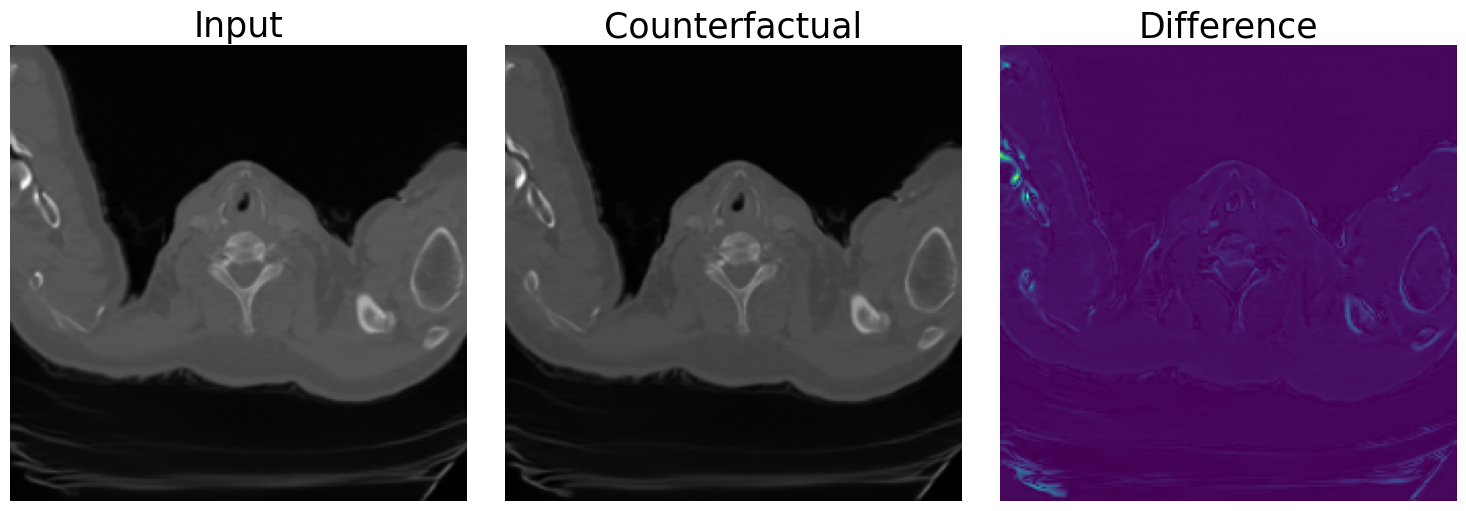

In [78]:
idx_slice =124
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0][:,::-1,idx_slice], cmap='gray')
axs[0].set_title('Input', size=25)
axs[1].imshow(images_counterfactual[0][:,::-1,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual', size=25)
axs[2].imshow(heatmaps1[0][:,::-1,idx_slice])
axs[2].set_title('Difference', size=25);
[axs[i].axis('off') for i in range(len(axs))]
plt.tight_layout()

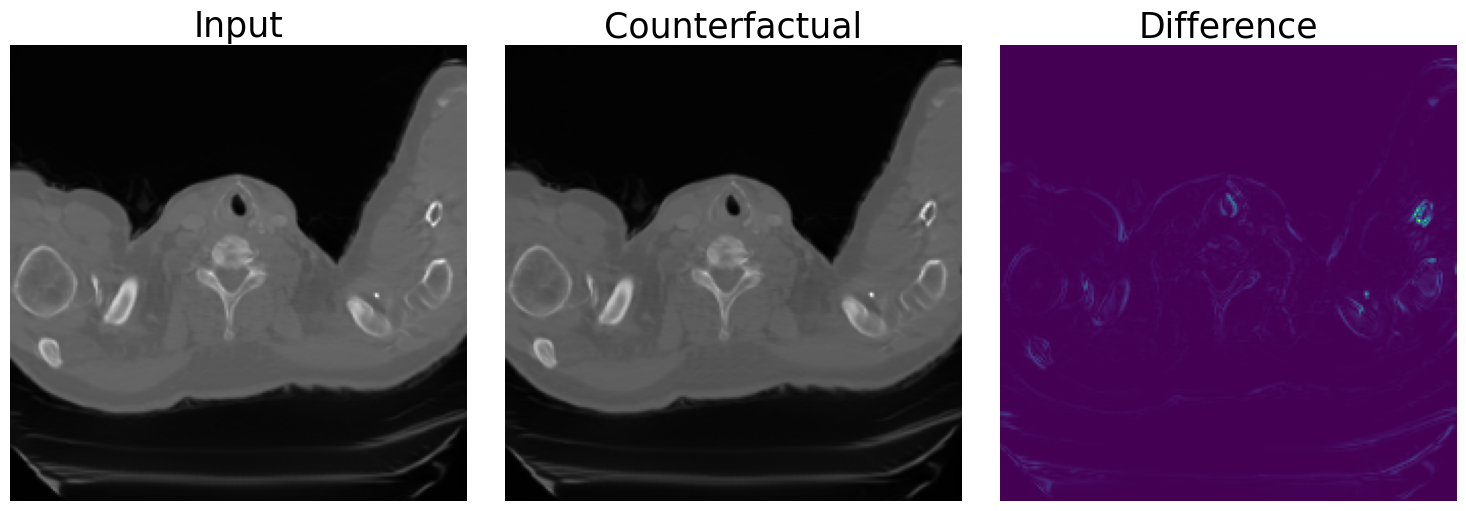

In [31]:
idx_slice = 120
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0][:,:,idx_slice], cmap='gray')
axs[0].set_title('Input', size=25)
axs[1].imshow(images_counterfactual[0][:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual', size=25)
axs[2].imshow(heatmaps1[0][:,:,idx_slice])
axs[2].set_title('Difference', size=25);
[axs[i].axis('off') for i in range(len(axs))]
plt.tight_layout()